In [1]:
%load_ext autoreload
%autoreload 2
RootDIR = "/home/jw3514/Work/ASD_Circuits_CellType/"
import sys
sys.path.insert(1, RootDIR + 'src')
from ASD_Circuits import *
from venn import venn
import requests
import json

# DownLoad Allen IDs

Download expression data and discontinued Entrez IDs

http://api.brain-map.org/class_detail/Gene

http://api.brain-map.org/examples/doc/structures/download_data.py.html

http://help.brain-map.org/display/api/Example+Queries+for+Experiment+Metadata

http://api.brain-map.org/doc/DataSet.html

https://ftp.ncbi.nih.gov/gene/README

In [4]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=model::SectionDataSet," +  \
   "rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse']," + \
   "treatments[name$eq'ISH'],genes,plane_of_section," + \
   "rma::options,[tabular$eq'plane_of_sections.name+as+plane'," + \
   "'genes.acronym+as+gene_acronym'," + \
   "'genes.entrez_id+as+genes_entrez_id'," + \
   "'genes.ensembl_id+as+gene_ensembl_id'," + \
   "'genes.alias_tags+as+gene_alias_tags'," + \
   "'data_sets.id+as+section_data_set_id']," + \
   "[order$eq'plane_of_sections.name,genes.acronym,data_sets.id']&" + \
   "start_row=0&num_rows=all"
print(url)
r = requests.get(url, allow_redirects=True)
open(RootDIR + 'dat/allen-mouse-exp/All_Mouse_Brain_ISH_experiments.csv', 'wb').write(r.content)


http://api.brain-map.org/api/v2/data/query.csv?criteria=model::SectionDataSet,rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse'],treatments[name$eq'ISH'],genes,plane_of_section,rma::options,[tabular$eq'plane_of_sections.name+as+plane','genes.acronym+as+gene_acronym','genes.entrez_id+as+genes_entrez_id','genes.ensembl_id+as+gene_ensembl_id','genes.alias_tags+as+gene_alias_tags','data_sets.id+as+section_data_set_id'],[order$eq'plane_of_sections.name,genes.acronym,data_sets.id']&start_row=0&num_rows=all


1569813

In [5]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene," +  \
   "rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse']," + \
   "[tabular$eq'acronym+as+gene_acronym'," + \
   "'gene_aliases.name+as+gene_aliases'," + \
   "'entrez_id+as+genes_entrez_id'," + \
   "[order$eq'acronym']&" + \
   "start_row=0&num_rows=all"
print(url)
r = requests.get(url, allow_redirects=True)
open(RootDIR + 'dat/allen-mouse-exp/All_Mouse_Brain_ISH_genes.csv', 'wb').write(r.content)


http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene,rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse'],[tabular$eq'acronym+as+gene_acronym','gene_aliases.name+as+gene_aliases','entrez_id+as+genes_entrez_id',[order$eq'acronym']&start_row=0&num_rows=all


469

In [6]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=" + \
        "model::Gene," + \
        "rma::criteria,products[abbreviation$eq'Mouse']," + \
        "rma::options,[tabular$eq'genes.id','genes.acronym+as+gene_symbol'," + \
        "'genes.name+as+gene_name','genes.entrez_id+as+entrez_gene_id'," + \
        "'genes.homologene_id+as+homologene_group_id'," + \
        "'genes.alias_tags+as+gene_alias_tags']," + \
        "[order$eq'genes.acronym']&num_rows=all&start_row=0"
print(url)
r = requests.get(url, allow_redirects=True)
open(RootDIR + 'dat/allen-mouse-exp/All_Mouse_Brain_Genes.csv', 'wb').write(r.content)


http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene,rma::criteria,products[abbreviation$eq'Mouse'],rma::options,[tabular$eq'genes.id','genes.acronym+as+gene_symbol','genes.name+as+gene_name','genes.entrez_id+as+entrez_gene_id','genes.homologene_id+as+homologene_group_id','genes.alias_tags+as+gene_alias_tags'],[order$eq'genes.acronym']&num_rows=all&start_row=0


1737396

# Mouse To Human Mapping

In [10]:
AllenMouseGenes = pd.read_csv(RootDIR + 'dat/allen-mouse-exp/All_Mouse_Brain_ISH_experiments.csv')
Human2MouseHom = pd.read_csv(RootDIR + 'dat/HOM_MouseHumanSequence.rpt', delimiter="\t")

In [11]:
Homo_IDs = set(Human2MouseHom["DB Class Key"].values)
print(len(Homo_IDs))

20602


In [12]:
Human2Mouse_Genes = {}
Mouse2Human_Genes = {}
# Key:EntrezID
# symbol: FOXP1
# mouseHomo: [(), ()]
# allen_section_data_set_id: [1,2]
for counter, ID in enumerate(Homo_IDs):
    tmp_df = Human2MouseHom[Human2MouseHom["DB Class Key"]==ID]
    #print(tmp_df)   
    hum_genes, mou_genes = [], []
    for i, row in tmp_df.iterrows():
        TaxonID = row["NCBI Taxon ID"]
        Symbol = row["Symbol"]
        Entrez = row["EntrezGene ID"]
        if  TaxonID == 9606:
            hum_genes.append((Symbol, Entrez))
        elif TaxonID == 10090:
            mou_genes.append((Symbol, Entrez))
    # Fill up Human2Mouse_Genes
    for (Symbol, Entrez) in hum_genes:
        if Entrez not in Human2Mouse_Genes:
            Human2Mouse_Genes[Entrez] = {}#mou_genes
            Human2Mouse_Genes[Entrez]["symbol"] = Symbol
            Human2Mouse_Genes[Entrez]["mouseHomo"] = mou_genes
        else:
            Human2Mouse_Genes[Entrez]["mouseHomo"].extend(mou_genes)
        
    # Fill up Mouse2Human_Genes
    for (Symbol, Entrez) in mou_genes:
        if Entrez not in Mouse2Human_Genes:
            Mouse2Human_Genes[Entrez] = {} #mou_genes
            Mouse2Human_Genes[Entrez]["symbol"] = Symbol
            Mouse2Human_Genes[Entrez]["humanHomo"] = hum_genes
            Mouse2Human_Genes[Entrez]["allen_section_data_set_id"] = []
        else:
            Mouse2Human_Genes[Entrez]["humanHomo"].extend(hum_genes)
            

In [13]:
Mouse2Human_Genes_2 = {}
for k,v in Mouse2Human_Genes.items():
    Mouse2Human_Genes_2[v["symbol"]] = {}
    Mouse2Human_Genes_2[v["symbol"]]["Entrez"] = k
    Mouse2Human_Genes_2[v["symbol"]]["humanHomo"] = v["humanHomo"]

In [14]:
pk.dump(Mouse2Human_Genes_2, open(RootDIR + 'dat/Mouse2Human_Symbol.pk', "wb"))
pk.dump(Mouse2Human_Genes, open(RootDIR + 'dat/Mouse2Human_Entrez.pk', "wb"))


In [15]:
Discontinued_ID = {}
df = pd.read_csv(RootDIR + 'dat/gene_history.human.mouse.tsv', delimiter="\t")
Discontinued_ID = dict(zip(df["Discontinued_GeneID"].values, df["GeneID"].values))


In [16]:
# Match Allen section_id to mouse genes with Entrez ID
def MatchAllen(symbol, entrez, row):
    # row: plane,gene_acronym,genes_entrez_id,gene_ensembl_id,gene_alias_tags,section_data_set_id
    #print(symbol, entrez)
    #print(row["gene_acronym"], row["genes_entrez_id"], row["gene_alias_tags"] )
    if str(row["genes_entrez_id"]) != "nan" and int(entrez) == int(row["genes_entrez_id"]):
        return row["section_data_set_id"]
    elif symbol == row["gene_acronym"]:
        return row["section_data_set_id"]
    else:
        if str(row["gene_alias_tags"]) == "nan":
            #print("haha")
            return None
        #print(str(row["gene_alias_tags"]), type(row["gene_alias_tags"]))
        for alias in row["gene_alias_tags"].split():
            alias = alias.strip()
            if alias == symbol:
                return row["section_data_set_id"]
    return None

Entrez_Failed_ID = []
for i, row in AllenMouseGenes.iterrows():
    if row["section_data_set_id"] == 68269058:
        print(row)
    if str(row["gene_acronym"]) != "nan":
        allen_symbol = row["gene_acronym"]
    else:
        allen_symbol = None
    if str(row["genes_entrez_id"]) != "nan":
        allen_entrez = int(row["genes_entrez_id"])
    else:
        allen_entrez = None
    if str(row["gene_alias_tags"]) != "nan":
        allen_alias = row["gene_alias_tags"].split()
    else:
        allen_alias = []
    allen_section_id = row["section_data_set_id"]
    try:
        potential_ID = int(Discontinued_ID[allen_entrez])
    except:
        potential_ID = -1
        pass
    if allen_entrez in Mouse2Human_Genes:
        Mouse2Human_Genes[allen_entrez]["allen_section_data_set_id"].append(allen_section_id)
    elif potential_ID in Mouse2Human_Genes:
        Mouse2Human_Genes[potential_ID]["allen_section_data_set_id"].append(allen_section_id)
    else:    
        Entrez_Failed_ID.append(allen_section_id)
 

plane                                sagittal
gene_acronym                            Spsb2
genes_entrez_id                       14794.0
gene_ensembl_id                           NaN
gene_alias_tags        AI461677 C9 Grcc9 SSB2
section_data_set_id                  68269058
Name: 22657, dtype: object


In [17]:
Mouse2Human_Genes[18430]

{'symbol': 'Oxtr',
 'humanHomo': [('OXTR', 5021)],
 'allen_section_data_set_id': [75081001, 78153167]}

In [18]:
68269058 in Entrez_Failed_ID

False

In [19]:
Mouse2Human_Genes

{14573: {'symbol': 'Gdnf',
  'humanHomo': [('GDNF', 2668)],
  'allen_section_data_set_id': [112647321, 69672862]},
 20845: {'symbol': 'Star',
  'humanHomo': [('STAR', 6770)],
  'allen_section_data_set_id': [69887325]},
 57265: {'symbol': 'Fzd2',
  'humanHomo': [('FZD2', 2535)],
  'allen_section_data_set_id': [81654103]},
 15396: {'symbol': 'Hoxa11',
  'humanHomo': [('HOXA11', 3207)],
  'allen_section_data_set_id': [69289135]},
 109663: {'symbol': 'Hoxc11',
  'humanHomo': [('HOXC11', 3227)],
  'allen_section_data_set_id': [81790682, 75990865]},
 640524: {'symbol': 'Sptbn5',
  'humanHomo': [('SPTBN5', 51332)],
  'allen_section_data_set_id': []},
 216049: {'symbol': 'Zfp365',
  'humanHomo': [('ZNF365', 22891)],
  'allen_section_data_set_id': [73929873, 70200776]},
 68980: {'symbol': 'Wdr53',
  'humanHomo': [('WDR53', 348793)],
  'allen_section_data_set_id': [68637461]},
 624784: {'symbol': 'Tdg-ps2',
  'humanHomo': [('TDG', 6996)],
  'allen_section_data_set_id': []},
 21665: {'symbol': 'T

In [20]:
print(len(Entrez_Failed_ID))

2718


In [21]:
# Check missed by entrez ID
Mouse_MissSectionID = []
for K, V in Mouse2Human_Genes.items():
    if len(V["allen_section_data_set_id"]) == 0:
        Mouse_MissSectionID.append(K)
print(len(Mouse_MissSectionID))

3393


In [22]:
Unlinked_AllenMouseGenes = AllenMouseGenes[AllenMouseGenes["section_data_set_id"].isin(
    Entrez_Failed_ID)]
Symbol_Failed_ID = []
Mapped_by_symbol = 0
Mapped_by_alias = 0
for i, row in Unlinked_AllenMouseGenes.iterrows():
    if row["section_data_set_id"] == 68269058:
        print(row)
    if str(row["gene_acronym"]) != "nan":
        allen_symbol = row["gene_acronym"]
    else:
        allen_symbol = None
    if str(row["gene_alias_tags"]) != "nan":
        allen_alias = row["gene_alias_tags"].split()
    else:
        allen_alias = []
    allen_section_id = row["section_data_set_id"]
    FLAG_FIND = False
    for k in Mouse_MissSectionID:
        symbol = Mouse2Human_Genes[k]["symbol"]
        if symbol.lower() == allen_symbol.lower():
            Mouse2Human_Genes[k]["allen_section_data_set_id"].append(allen_section_id)
            FLAG_FIND = True
            Mapped_by_symbol += 1
            break
        else:
            for alias in allen_alias:
                if alias == "C9":
                    print(row)
                if alias.lower() == symbol.lower():
                    Mouse2Human_Genes[k]["allen_section_data_set_id"].append(allen_section_id)
                    FLAG_FIND = True
                    Mapped_by_alias += 1
                    print(alias)
                    break
    if not FLAG_FIND:
        Symbol_Failed_ID.append(allen_section_id)
print(Mapped_by_symbol, Mapped_by_alias)
print(len(Symbol_Failed_ID))

Nrbf2
TRDV4
Ndufs5
Ndufs5
A930017K11Rik
5530400C23Rik
Nrbf2
Abcb5
Ddx23
Atp8b4
Myo18b
Sp5
Pramel5
1 13
2704


In [23]:
Unlinked_AllenMouseGenes = AllenMouseGenes[AllenMouseGenes["section_data_set_id"].isin(
    Symbol_Failed_ID)]

In [24]:
Unlinked_AllenMouseGenes

,plane,gene_acronym,genes_entrez_id,gene_ensembl_id,gene_alias_tags,section_data_set_id
6,coronal,1200016E24Rik,319202.0,NaN,NaN,1591
13,coronal,2610028E06Rik,72395.0,NaN,BB043107,71020430
15,coronal,3100002H09Rik,70249.0,NaN,NaN,77340484
19,coronal,4833414E09Rik,71633.0,NaN,AI593012,73521828
26,coronal,5330421K23Rik*,NaN,NaN,NaN,75043138
...,...,...,...,...,...,...
25955,sagittal,Zfp955a,77652.0,NaN,A430003O12Rik AI842447 C430039G02Rik C530035A1...,71210971
25990,sagittal,Zim2,76637.0,NaN,1700116N21Rik,71920213
26021,sagittal,Znf41-ps,70005.0,NaN,NaN,69134250
26056,sagittal,Zscan4a,434555.0,NaN,BQ559217 LOC434555 XM_486399,68667234


In [25]:
DIR = RootDIR + 'dat/allen-mouse-exp/'
with open(DIR + 'human2mouse.0420.json', 'w') as outfile:
    json.dump(Human2Mouse_Genes, outfile)
with open(DIR + 'mouse2sectionID.0420.json', 'w') as outfile:
    json.dump(Mouse2Human_Genes, outfile)
Unlinked_AllenMouseGenes.to_csv(DIR + "Allen_Unlinked_SectionIDs.0415.csv", index=False)

In [26]:
Mouse2Human_Genes

{14573: {'symbol': 'Gdnf',
  'humanHomo': [('GDNF', 2668)],
  'allen_section_data_set_id': [112647321, 69672862]},
 20845: {'symbol': 'Star',
  'humanHomo': [('STAR', 6770)],
  'allen_section_data_set_id': [69887325]},
 57265: {'symbol': 'Fzd2',
  'humanHomo': [('FZD2', 2535)],
  'allen_section_data_set_id': [81654103]},
 15396: {'symbol': 'Hoxa11',
  'humanHomo': [('HOXA11', 3207)],
  'allen_section_data_set_id': [69289135]},
 109663: {'symbol': 'Hoxc11',
  'humanHomo': [('HOXC11', 3227)],
  'allen_section_data_set_id': [81790682, 75990865]},
 640524: {'symbol': 'Sptbn5',
  'humanHomo': [('SPTBN5', 51332)],
  'allen_section_data_set_id': []},
 216049: {'symbol': 'Zfp365',
  'humanHomo': [('ZNF365', 22891)],
  'allen_section_data_set_id': [73929873, 70200776]},
 68980: {'symbol': 'Wdr53',
  'humanHomo': [('WDR53', 348793)],
  'allen_section_data_set_id': [68637461]},
 624784: {'symbol': 'Tdg-ps2',
  'humanHomo': [('TDG', 6996)],
  'allen_section_data_set_id': []},
 21665: {'symbol': 'T

In [27]:
Mouse_MissSectionID = []
for K, V in Mouse2Human_Genes.items():
    if len(V["allen_section_data_set_id"]) == 0:
        Mouse_MissSectionID.append(K)
print(len(Mouse_MissSectionID))

3381


# Expression Level Mat construction

In [29]:
STR_Meta = pd.read_csv(RootDIR + 'dat/allen-mouse-exp/allen_brain_atlas_structures.csv')
STR_Meta.dropna(inplace=True, subset=["atlas_id"])
STR_Meta["atlas_id"] = STR_Meta["atlas_id"].astype(int)
#STR_Meta["parent_structure_id"] = STR_Meta["parent_structure_id"].astype(int)
STR_Meta = STR_Meta.set_index("atlas_id")
for i, row in STR_Meta.iterrows():
    STR_Meta.loc[i, "Name2"] = modify_str(row["safe_name"])


In [30]:
STR_Meta[STR_Meta["depth"]==0]

,id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,graph_id,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,Name2
atlas_id,,,,,,,,,,,,,,,,,,,,,
-1,997,root,root,0,1,3,8690,NaN,0,1,...,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root,root


In [31]:
Selected_STRs = LoadList(RootDIR + 'dat/allen-mouse-exp/Structures.txt')


In [32]:
STR_Meta_2 = STR_Meta[STR_Meta["Name2"].isin(Selected_STRs)]
STR_Meta_2 = STR_Meta_2.sort_values("Name2")
STR_Meta_2.to_csv(RootDIR + 'dat/allen-mouse-exp/Selected_213_STRs.Meta.csv')


In [39]:
STR_Meta_2.head(2)

,id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,graph_id,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,Name2
atlas_id,,,,,,,,,,,,,,,,,,,,,
18,151,Accessory olfactory bulb,AOB,8,1,3,8690,698.0,6,1,...,/997/8/567/688/695/698/151/,9DF0D2,NaN,NaN,f,387,3386724067,734881840,Accessory olfactory bulb,Accessory_olfactory_bulb
12,104,"Agranular insular area, dorsal part",AId,9,1,3,8690,95.0,7,1,...,/997/8/567/688/695/315/95/104/,219866,NaN,NaN,f,280,289370996,734881840,Agranular insular area dorsal part,Agranular_insular_area_dorsal_part


In [40]:
Count1, Count2, Count3 = 0,0,0
for K, V in Mouse2Human_Genes.items():
    Count1 += 1
    #print(V)
    if len(V["humanHomo"])>0:
        Count2 += 1
    if len(V["allen_section_data_set_id"]) > 0:
        Count3 += 1
print(Count1, Count2, Count3)

20600 19545 17219


In [41]:
# Check Human Genes
Count1, Count2, Count3 = 0,0,0
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Count1 += 1
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    if len(mouseHomo) > 0:
        Count2 += 1
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"] 
        g_All_Section_ID.extend(section_ids)
    #PRINT(g_All_Section_ID)
    if len(g_All_Section_ID) > 0:
        Count3 += 1
print(Count1, Count2, Count3)

18981 18980 17196


In [46]:
# Check Exp Level Cross Expriments
DataDIR = RootDIR + 'dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/'
All_Genes = []
All_ExpEnergy = []
Counts = 0

Exp1 = []
Exp2 = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    if len(g_All_Section_ID) <= 1:
        continue

    g_All_dat = []
    for section in g_All_Section_ID:
        dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
        _ = dat_df[dat_df["structure_id"]==997]
        if len(_) > 0:
            exp_energy = _["expression_energy"].values[0]
            g_All_dat.append(exp_energy)
        else:
            continue
    #print(entrez, Symbol, v["mouseHomo"], g_All_Section_ID)
    #print(g_All_dat)
    if len(g_All_dat)>=2:
        Exp1.append(g_All_dat[0])
        Exp2.append(g_All_dat[1])

    Counts += 1
    #if Counts > 1000:
    #    break


In [47]:
print(len(Exp1), len(Exp2))

17123 17123


PearsonRResult(statistic=0.9200520271002165, pvalue=0.0)


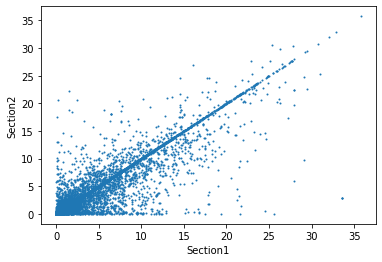

In [48]:
plt.scatter(Exp1, Exp2, s=1)
plt.xlabel("Section1")
plt.ylabel("Section2")
print(pearsonr(Exp1, Exp2))

In [49]:
# Get Root Expression
# Check Exp Level Cross Expriments
DataDIR = RootDIR + 'dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/'
All_Genes = []
All_ExpEnergy = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    g_All_dat = []
    for section in g_All_Section_ID:
        dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
        _ = dat_df[dat_df["structure_id"]==997]
        if len(_) > 0:
            exp_energy = _["expression_energy"].values[0]
            g_All_dat.append(exp_energy)
    g_avg_exp_energy = np.nanmean(g_All_dat)
    All_ExpEnergy.append(g_avg_exp_energy)
All_ExpEnergy = np.array(All_ExpEnergy)    
        

/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat)
/tmp/ipykernel_1576007/4210890088.py:20:

In [50]:
print(len(All_ExpEnergy), len(Human2Mouse_Genes.keys()))

18981 18981


In [51]:
df = pd.DataFrame(data={"Genes":list(Human2Mouse_Genes.keys()), "EXP":All_ExpEnergy})
df = df.dropna(subset=["EXP"])
df.shape

(17189, 2)

In [52]:
df.to_csv(RootDIR + 'dat/allen-mouse-exp/ExpMatchFeatures.csv', index=False)


In [7]:
#Human2Mouse_Genes = json.load(open(RootDIR + 'dat/allen-mouse-exp/human2mouse.0420.json', "r"))
#Mouse2Human_Genes = json.load(open(RootDIR + 'dat/allen-mouse-exp/mouse2sectionID.0420.json', "r"))

In [33]:
DataDIR = RootDIR + 'dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/'
All_Genes = []
All_ExpEnergy = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    #print(g_All_Section_ID)
    g_All_dat = []
    if len(g_All_Section_ID) <= 0:
        continue
    for section in g_All_Section_ID:
        #print(section)
        dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
        #print(dat_df)
        dat = []
        for str_id, row in STR_Meta_2.iterrows():
            _id = row["id"]
            _ = dat_df[dat_df["structure_id"]==_id]
            if len(_) > 0:
                exp_energy = np.log2(1+_["expression_energy"].values[0])
            else:
                exp_energy = np.nan
                
            dat.append(exp_energy)
        g_All_dat.append(dat)
    g_All_dat = np.array(g_All_dat)
    #print(g_All_dat)
    
    g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
    #print(g_avg_exp_energy)
    
    All_Genes.append(entrez)
    All_ExpEnergy.append(g_avg_exp_energy)
    
All_ExpEnergy = np.array(All_ExpEnergy)    


/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
/tmp/ipykernel_1604783/3014430256.py:33: RuntimeWarning: Mean of empty slice
  g_avg_exp_energy = np.nan

In [34]:
ExpMat = pd.DataFrame(data=All_ExpEnergy, index=All_Genes, columns=STR_Meta_2["Name2"].values)
ExpMat2 = ExpMat.dropna(axis=0, how='all', inplace=False)
print(ExpMat2.shape, ExpMat.shape)

(17189, 213) (17196, 213)


In [35]:
ExpMat.to_csv(RootDIR + 'dat/allen-mouse-exp/ExpLevel.csv.gz', compression='gzip')


In [37]:
ExpMat.head(2)

,Accessory_olfactory_bulb,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Ansiform_lobule,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Anterior_hypothalamic_nucleus,Anterior_olfactory_nucleus,...,Ventral_cochlear_nucleus,Ventral_medial_nucleus_of_the_thalamus,Ventral_part_of_the_lateral_geniculate_complex,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Ventromedial_hypothalamic_nucleus,Visceral_area,posteromedial_visual_area
2668,3.682287,2.878418,2.677806,2.710411,3.000677,2.256930,2.413446,2.268135,2.153733,2.836966,...,1.989196,1.906333,1.960055,2.199955,2.465963,1.830818,1.979135,2.299263,2.630536,2.603273
6770,1.436167,1.161862,0.723577,1.046512,0.724732,1.447246,1.390882,0.557868,0.141192,1.106851,...,0.336914,0.256555,0.603247,1.144621,1.591861,0.572919,0.345350,0.040313,0.690253,0.823324


# Expression Zscore

In [36]:
ExpZscoreMat = ZscoreConverting(ExpMat)
ExpZscoreMat.to_csv(RootDIR + 'dat/allen-mouse-exp/ExpLevel.Zscore.csv.gz', compression='gzip')

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U64'), dtype('<U64')) -> None

In [254]:
#exp_level = pd.read_csv("../dat/allen-mouse-exp/jon/exp_level-before_norm.csv", 
#                           index_col="ROW")
ExpMat = pd.read_csv("dat/jon_data/expression_energy-human-connectome_struc-log2-qn.csv", 
                           index_col="ROW")
ExpMat = ExpMat.loc[Genes,:]
#ExpMat = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.0418.csv", 
#                           index_col=0)

In [255]:
#ExpMat_Log = ExpMat.copy(deep=True)
#for c in ExpMat.columns.values:
#    ExpMat[c] = np.log2(1+ExpMat_Log[c])
#ExpMat_Log_QN = quantileNormalize(ExpMat)
#ExpMat_Log.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.log2.0418.csv")


In [256]:
df_z = []
for i in ExpMat.index.values :
    i_z = ZscoreConverting(ExpMat.loc[i,:].values)
    df_z.append(i_z)
ExpZscoreMat = pd.DataFrame(data=df_z, 
                            columns=ExpMat.columns.values, 
                            index=ExpMat.index.values)

ExpZscoreMat.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/AllenMouse_z1_mat.0511.csv")


In [320]:
ExpMat_Log_QN = quantileNormalize(ExpMat_Log)
df_z = []
for i in ExpMat_Log_QN.index.values :
    i_z = ZscoreConverting(ExpMat_Log_QN.loc[i,:].values)
    df_z.append(i_z)
ExpZscoreMat2 = pd.DataFrame(data=df_z, 
                            columns=ExpMat_Log_QN.columns.values, 
                            index=ExpMat_Log_QN.index.values)
ExpZscoreMat2.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_z1_mat.qn.0418.csv")




### Combine Z2 Matrix

In [264]:
Z2_split_dir = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/Mouse.Mean.UniformKernel.Z2scores/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/AllenMouseBrain_Z2bias.csv")

In [2]:
Z2_split_dir = "../dat/AllenMouse.BrainSpanMatch.Z2scores/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("../dat/allen-mouse-exp/AllenMouseBrain_Z2bias.brainspanMatch.csv")

SpearmanrResult(correlation=0.9894225904935373, pvalue=0.0)
(0.9896886583020557, 0.0)


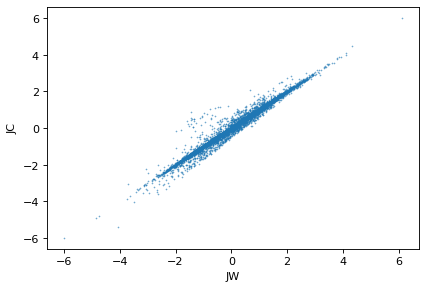

In [266]:
JC_Z2 = pd.read_csv("dat/Jon_data/exp_bias.csv", index_col=0)
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in JC_Z2.columns.values:
        x1 = Z2_MAt.loc[g, str_]
        x2 = JC_Z2.loc[g, str_]
        if x1 == x1 and x2 == x2:
            dat1.append(x1)
            dat2.append(x2)
plt.scatter(dat1, dat2, s=0.1)
plt.xlabel("JW")
plt.ylabel("JC")
print(spearmanr(dat1, dat2, nan_policy="omit"))
print(pearsonr(dat1, dat2))

In [3]:
# Z2 Mat with neuron norm

Z2_split_dir = "../dat/AllenMouse.NeuroNorm.Z2score/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("../dat/allen-mouse-exp/AllenMouseBrain_Z2bias.neuronorm.csv")